## 1. Load Data

In [2]:
include("src/objects/Polypeptide.jl")

X = from_pdb("1A3N", "A")
Y = from_pdb("1A3N", "B")
render_aligned(X, Y)

[ Info: File exists: 1A3N
[ Info: File exists: 1A3N
[ Info: Superimposing based on a sequence alignment between 138 residues
[ Info: Superimposing based on 138 atoms
[ Info: Model 1 with 2 chains (1,2), 286 residues, 2507 atoms


HTML{String}("<script type='text/javascript'>/*! jQuery v3.3.1 | (c) JS Foundation and other contributors | jquery.org/license */\n!function(e,t){\"use strict\";\"object\"==typeof module&&\"object\"==typeof module.exports?module.exports=e.document?t(e,!0):function(e){if(!e.document)throw new Error(\"jQuery requires a window with a document\");return t(e)}:t(e)}(\"undefined\"!=typeof window?window:this,function(e,t){\"use strict\";var n=[],r=e.document,i=Object.getPrototypeOf,o=n.slice,a=n.concat,s=n.push,u=n.indexOf,l={},c=l.toString,f=l.hasOwnProperty,p=f.toString,d=p.call(Object),h={},g=function e(t){return\"function\"==typeof t&&\"number\"!=typeof t.nodeType},y=function e(t){return null!=t&&t===t.window},v={type:!0,src:!0,noModule:!0};function m(e,t,n){var i,o=(t=t||r).createElement(\"script\");if(o.text=e,n)for(i in v)n[i]&&(o[i]=n[i]);t.head.appendChild(o).parentNode.removeChild(o)}function x(e){return null==e?e+\"\":\"object\"==typeof e||\"function\"==typeof e?l[c.call(e)]||\"object\":typeof e}var b=\"3.3.1\",w=function(e,t){return new w.fn.init(e,t)},T=/^[\\s\\uFEFF\\xA0]+|[\\s\\uFEFF\\xA0]+\$/g;w.fn=w.prototype={jquery:\"3.3.1\",constructor:w,length:0,toArray:function(){return o.call(this)},get:function(e){return null==e?o.call(this):e<0?this[e+this.length]:this[e]},pushStack:function(e){var t=w.merge(this.constructor(),e);return t.prevObject=this,t},each:function(e){return w.each(this,e)},map:function(e){return this.pushStack(w.map(this,function(t,n){return e.call(t,n,t)}))},slice:function(){return this.pushStack(o.apply(this,arguments))},first:function(){return this.eq(0)},last:function(){return this.eq(-1)},eq:function(e){var t=this.length,n=+e+(e<0?t:0);return this.pushStack(n>=0&&n<t?[this[n]]:[])},end:function(){return this.prevObject||this.constructor()},push:s,sort:n.sort,splice:n.splice},w.extend=w.fn.extend=function(){var e,t,n,r,i,o,a=arguments[0]||{},s=1,u=arguments.length,l=!1;for(\"boolean\"==typeof a&&(l=a,a=arguments[s]||{},s++),\"object\"==typeof a||g(a)||(a={}),s===u&&(a=this,s--);s<u;s++)if(null!=(e=arguments[s]))for(t in e)n=a[t],a!==(r=e[t])&&(l&&r&&(w.isPlainObject(r)||(i=Array.isArray(r)))?(i?(i=!1,o=n&&Array.isArray(n)?n:[]):o=n&&w.isPlainObject(n)?n:{},a[t]=w.extend(l,o,r)):void 0!==r&&(a[t]=r));return a},w.extend({expando:\"jQuery\"+(\"3.3.1\"+Math.random()).replace(/\\D/g,\"\"),isReady:!0,error:function(e){throw new Error(e)},noop:function(){},isPlainObject:function(e){var t,n;return!(!e||\"[object Object]\"!==c.call(e))&&(!(t=i(e))||\"function\"==typeof(n=f.call(t,\"constructor\")&&t.constructor)&&p.call(n)===d)},isEmptyObject:function(e){var t;for(t in e)return!1;return!0},globalEval:function(e){m(e)},each:function(e,t){var n,r=0;if(C(e)){for(n=e.length;r<n;r++)if(!1===t.call(e[r],r,e[r]))break}else for(r in e)if(!1===t.call(e[r],r,e[r]))break;return e},trim:function(e){return null==e?\"\":(e+\"\").replace(T,\"\")},makeArray:function(e,t){var n=t||[];return null!=e&&(C(Object(e))?w.merge(n,\"string\"==typeof e?[e]:e):s.call(n,e)),n},inArray:function(e,t,n){return null==t?-1:u.call(t,e,n)},merge:function(e,t){for(var n=+t.length,r=0,i=e.length;r<n;r++)e[i++]=t[r];return e.length=i,e},grep:function(e,t,n){for(var r,i=[],o=0,a=e.length,s=!n;o<a;o++)(r=!t(e[o],o))!==s&&i.push(e[o]);return i},map:function(e,t,n){var r,i,o=0,s=[];if(C(e))for(r=e.length;o<r;o++)null!=(i=t(e[o],o,n))&&s.push(i);else for(o in e)null!=(i=t(e[o],o,n))&&s.push(i);return a.apply([],s)},guid:1,support:h}),\"function\"==typeof Symbol&&(w.fn[Symbol.iterator]=n[Symbol.iterator]),w.each(\"Boolean Number String Function Array Date RegExp Object Error Symbol\".split(\" \"),function(e,t){l[\"[object \"+t+\"]\"]=t.toLowerCase()});function C(e){var t=!!e&&\"length\"in e&&e.length,n=x(e);return!g(e)&&!y(e)&&(\"array\"===n||0===t||\"number\"==typeof t&&t>0&&t-1 in e)}var E=function(e){var t,n,r,i,o,a,s,u,l,c,f,p,d,h,g,y,v,m,x,b=\"sizzle\"+1*new Date,w=e.document,T=0,C=0,E=ae(),k=ae(),S=ae(),D=function(e,t){return e===t&&(f=!0),0},N

## 2. Prepare Evolutionary Regimes

In [31]:
include("src/distributions/WrappedNormal.jl")
include("src/distributions/Processes.jl")
include("src/distributions/WrappedDiffusion.jl")
include("src/distributions/Common.jl")
include("src/distributions/JumpingProcess.jl")
using Base.Threads

diff = WrappedDiffusion([0.0, 1.0], 3.0, 1.0, 1.0, 2.0, 0.1)
jump = jumping(diff, 100.0)
t = 0.5;
x = rand(unwrapped(statdist(diff)), 1000)
y = rand(statdist(diff), 1000)
r = rand(1000, 1000)
nthreads()

1

In [35]:
tt = transdist(jump, t, x[:, 1])
@time logpdf(tt, y);

  0.026661 seconds (203.01 k allocations: 10.933 MiB, 29.22% gc time)


In [36]:
@time exp.(jointlogpdf!(r, diff, t, x, y));
@time exp.(jointlogpdf!(r, jump, t, x, y));

 15.469515 seconds (162.12 M allocations: 8.585 GiB, 8.32% gc time)
 23.311478 seconds (217.86 M allocations: 12.540 GiB, 8.45% gc time)


In [27]:
#200 x 200 
@time begin 
    @threads for i ∈ axes(x, 2)
        logpdf(statdist(diff), x)
    end
end
@time begin 
    @threads for i ∈ axes(x, 2)
        logpdf(tt[i], x)
    end
end

  0.213106 seconds (1.80 M allocations: 113.779 MiB, 6.58% gc time, 28.82% compilation time)


LoadError: TaskFailedException

[91m    nested task error: [39mUndefVarError: `tt` not defined
    Stacktrace:
     [1] [0m[1mmacro expansion[22m
    [90m   @[39m [90m.\[39m[90m[4mIn[27]:9[24m[39m[90m [inlined][39m
     [2] [0m[1m(::var"#373#threadsfor_fun#51"{var"#373#threadsfor_fun#50#52"{Base.OneTo{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMain[39m [90m.\[39m[90m[4mthreadingconstructs.jl:140[24m[39m
     [3] [0m[1m#373#threadsfor_fun[22m
    [90m   @[39m [90m.\[39m[90m[4mthreadingconstructs.jl:107[24m[39m[90m [inlined][39m
     [4] [0m[1m(::Base.Threads.var"#1#2"{var"#373#threadsfor_fun#51"{var"#373#threadsfor_fun#50#52"{Base.OneTo{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m.\[39m[90m[4mthreadingconstructs.jl:85[24m[39m

In [45]:
using Turingn
using StatsPlots 

@model function wnn(x)
    mean ~ filldist(Uniform(-π, π), 2)
    var1 ~ Exponential(1.0)
    var2 ~ Exponential(1.0)
    Θ = (mean, var1, var2, 1.0, 1.0, 0.0)
    diff = WrappedDiffusion(Θ...)
    Threads.@threads for i ∈ axes(x, 2)
        x[:,i] .~ statdist(diff)
    end
end

@model function fun(x, y)
    t ~ Exponential(1.0)
    mean ~ filldist(Uniform(-π, π), 2)
    var1 ~ Exponential(1.0)
    var2 ~ Exponential(1.0)
    Θ = (mean, var1, var2, 1.0, 1.0, 0.0)
    diff = WrappedDiffusion(Θ...)

    Threads.@threads for i ∈ axes(x, 2)
        x[:,i] .~ statdist(diff)
        y[:,i] .~ transdist(diff, t, x[:, i])
    end

end

fun (generic function with 2 methods)

In [46]:
alg = HMC(0.05, 10, :mean, :var)
alg2 = Gibbs(MH(:mean), MH(:var1), MH(:var2), MH(:t))
l=200
model = wnn(x[:, 1:l])
model2 = fun(x[:, 1:l], y[:, 1:l])
num_samples = 100
ch = sample(model2, alg2, num_samples)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:51


LoadError: InterruptException:

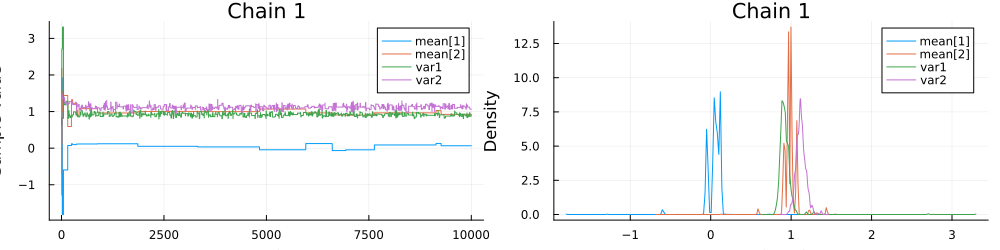

In [42]:
plot(ch[["mean[1]", "mean[2]", "var1", "var2"]]; colordim=:parameter, legend=true)

In [96]:

using Turing, ReverseDiff
using FillArrays

Turing.setadbackend(:reversediff);
Turing.setrdcache(true)
# Define Gaussian mixture model.
w = [0.5, 0.5]
μ = [-3.5, 0.5]
mixturemodel = MixtureModel([MvNormal(Fill(μₖ, 2), I) for μₖ in μ], w)

# We draw the data points.
N = 60
x = rand(mixturemodel, N);
scatter(x[1, :], x[2, :]; legend=false, title="Synthetic Dataset")

@model function gaussian_mixture_model(x)
    # Draw the parameters for each of the K=2 clusters from a standard normal distribution.
    K = 2
    μ ~ MvNormal(Zeros(K), I)

    # Draw the weights for the K clusters from a Dirichlet distribution with parameters αₖ = 1.
    w ~ Dirichlet(K, 1.0)
    # Alternatively, one could use a fixed set of weights.
    # w = fill(1/K, K)

    # Construct categorical distribution of assignments.
    distribution_assignments = Categorical(w)

    # Construct multivariate normal distributions of each cluster.
    D, N = size(x)
    distribution_clusters = [MvNormal(Fill(μₖ, D), I) for μₖ in μ]

    # Draw assignments for each datum and generate it from the multivariate normal distribution.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ distribution_assignments
        x[:, i] ~ distribution_clusters[k[i]]
    end

    return k
end

model = gaussian_mixture_model(x);

In [114]:
sampler = Gibbs(PG(50, :k), HMC(0.05, 10, :μ, :w))
sampler2 = Gibbs(PG(50, :k), MH(:μ), MH(:w))
nchains = 1
nsamples=30
chains = sample(model, sampler2, MCMCThreads(), nsamples, nchains);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC D:\Programs\julia_depot\packages\AbstractMCMC\F9Hbk\src\sample.jl:296


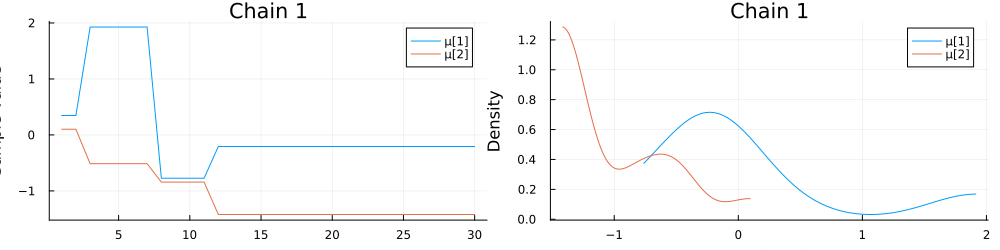

In [115]:
plot(chains[["μ[1]", "μ[2]"]]; colordim=:parameter, legend=true)

In [20]:
import Pkg; Pkg.add("Bijectors"); using Bijectors

   Resolving package versions...
    Updating `C:\Users\stefa\Dropbox\Jotun Hein - Part C Projects\Manolache\Code\Evolutionary Toroidal Difussions\TorusEvol\Project.toml`
⌅ [76274a88] + Bijectors v0.10.8
  No Changes to `C:\Users\stefa\Dropbox\Jotun Hein - Part C Projects\Manolache\Code\Evolutionary Toroidal Difussions\TorusEvol\Manifest.toml`


In [21]:
n = MvNormal(rand(2), I)

IsoNormal(
dim: 2
μ: [0.06035521128889432, 0.9851929665422794]
Σ: [1.0 0.0; 0.0 1.0]
)


In [53]:
b = Beta()
c = filldist(Beta(), 10)
bijector(c)

Bijectors.Logit{1, Float64}(0.0, 1.0)

In [52]:
Bijectors.bijector(wn::WrappedNormal) = Bijectors.Logit{1, Real}(-π, π)
[]
bijector(statdist(diff))

Bijectors.Logit{1, Real}(-3.141592653589793, π)